Amazon review data

https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

In [4]:
import bz2
from pathlib import Path

import numpy as np
import pandas as pd


def get_data(file_name: Path):
    reviews = bz2.BZ2File(file_name).readlines()
    reviews = [review.decode("utf-8") for review in reviews]
    target = {'1':'Negative', '2':'Positive'}
    
    label = [target[label[9]] for label in reviews]
    reviews = [review[11:] for review in reviews]
    df = pd.DataFrame(data = {"label":label, "review": reviews})
    return df

In [7]:
path = Path("../../data")
train = get_data(path / "train.ft.txt.bz2").sample(140000, random_state=0)
test = get_data(path / "test.ft.txt.bz2")

In [8]:
test.head()

,label,review
0,Positive,Great CD: My lovely Pat has one of the GREAT v...
1,Positive,One of the best game music soundtracks - for a...
2,Negative,Batteries died within a year ...: I bought thi...
3,Positive,"works fine, but Maha Energy is better: Check o..."
4,Positive,Great for the non-audiophile: Reviewed quite a...


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [10]:
vec = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3, 
    max_df=0.9, 
    strip_accents='unicode', 
    use_idf=1,
    smooth_idf=1, 
    sublinear_tf=1
)

encoder = LabelEncoder()

In [11]:
X_train = vec.fit_transform(train['review'])
X_test = vec.transform(test['review'])
Y_train = encoder.fit_transform(train['label'])
Y_test = encoder.transform(test['label'])

In [12]:
log_model = LogisticRegression(
    C=4, dual=True, solver='liblinear', random_state=42
)
log_model.fit(X_train, Y_train)

LogisticRegression(C=4, dual=True, random_state=42, solver='liblinear')

/home/alberto/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


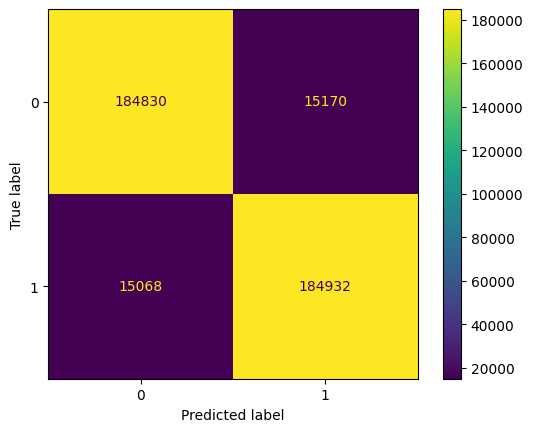

In [13]:
plot_confusion_matrix(log_model, X_test, Y_test);

In [14]:
from sklearn.metrics import classification_report

y_pred = log_model.predict(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92    200000
           1       0.92      0.92      0.92    200000

    accuracy                           0.92    400000
   macro avg       0.92      0.92      0.92    400000
weighted avg       0.92      0.92      0.92    400000



In [17]:
import eli5

eli5.show_weights(
    estimator=log_model, 
    feature_names= list(vec.get_feature_names()),
    top=(20,20)
)

2024-02-15 11:37:16.666464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 11:37:17.607667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-15 11:37:17.607758: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-02-15 11:37:17.769147: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 11:37:19.635219: W tensorflow/stream_executor/platform/de

Weight?,Feature
+22.435,great
+18.596,excellent
+13.744,perfect
+12.913,awesome
+11.689,good
+11.462,amazing
+11.317,best
+10.794,love
+10.605,wonderful
+9.680,better than


## BERT

In [21]:
from typing import List, Mapping

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoConfig, AutoModel, AutoTokenizer

device = torch.device("cpu")
MODEL_NAME = 'distilbert-base-uncased'
NUM_EPOCHS = 1
LEARNING_RATE = 5e-5
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 100

class ReviewDataset(Dataset):

    def __init__(
        self,
        sentences: List[str],
        labels: List[str] = None,
        max_seq_length: int = MAX_SEQ_LENGTH,
        model_name: str = 'distilbert-base-uncased'
    ):

        self.sentences = sentences
        self.labels = labels
        self.max_seq_length = max_seq_length

        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        
    def __len__(self):
        return len(self.sentences)

    
    def __getitem__(self, index) -> Mapping[str, torch.Tensor]:
        sentence = self.sentences[index]
        encoded = self.tokenizer.encode_plus(
            sentence, 
            add_special_tokens=True, 
            padding="max_length", 
            max_length=self.max_seq_length,
            truncation=True,
            return_token_type_ids=True
        )
        
        output = {
            'input_ids': torch.tensor(encoded['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoded['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.labels[index], dtype=torch.long)
        }
        
        return output

In [22]:
train = train.sample(1000)
test = test.sample(1000)

train_dataset = ReviewDataset(
    sentences=train['review'].values.tolist(),
    labels=train['label'].map({"Negative": 0, "Positive": 1}).values,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

valid_dataset = ReviewDataset(
    sentences=test['review'].values.tolist(),
    labels=test['label'].map({"Negative": 0, "Positive": 1}).values,
    max_seq_length=MAX_SEQ_LENGTH,
    model_name=MODEL_NAME
)

tokenizer_config.json: 100%|██████████| 28.0/28.0 [00:00<00:00, 1.35kB/s]
config.json: 100%|██████████| 483/483 [00:00<00:00, 174kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 2.34MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.52MB/s]


In [23]:
training_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2,
)

In [25]:
class DistilBert(nn.Module):

    def __init__(self, pretrained_model_name: str = MODEL_NAME, num_classes: int = 2):

        super().__init__()

        config = AutoConfig.from_pretrained(
             pretrained_model_name
        )
        self.distilbert = AutoModel.from_pretrained(
            pretrained_model_name,
            config=config
        )
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        self.classifier = nn.Linear(config.dim, num_classes)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

    def forward(self, input_ids, attention_mask):

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )
        hidden_state = distilbert_output[0] 
        pooled_output = hidden_state[:, 0] 
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [28]:
model = DistilBert()

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LEARNING_RATE
)

In [1]:
model.train()

for epoch in range(NUM_EPOCHS):
    for step, data in enumerate(training_loader):
        
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)

        outputs = model(ids, mask)

        optimizer.zero_grad()

        loss = F.nll_loss(outputs, targets, weight=torch.tensor([1., 1.]).to(device))
        print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

NameError: name 'model' is not defined

In [ ]:
model.eval()

labels = []
confidences = []
probs = []
with torch.no_grad():
    for data in valid_loader:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)

        outputs = model(ids, mask)
        prob = outputs.data.exp()
        confidence, idx = torch.max(prob, dim=-1)

        labels.append(idx)
        confidences.append(confidence.tolist())
        probs.append(prob.tolist())

labels = np.concatenate(labels, axis=0)
confidences = np.concatenate(confidences, axis=0)
probs = np.concatenate(probs, axis=0)

## Embedding + LSTM

In [ ]:
import nltk

#nltk.download('punkt')

train_sentences = [ nltk.word_tokenize(review) for review in train["review"].str.lower() ]
test_sentences = [ nltk.word_tokenize(review) for review in test["review"].str.lower() ]

words = set([ token for sentence in train_sentences for token in sentence ])
words |= {"_PAD", "_UNK"}

word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

for i, sentence in enumerate(train_sentences):
    # Looking up the mapping dictionary and assigning the index to the respective words
    train_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]
    
for i, sentence in enumerate(test_sentences):
    # For test sentences, we have to tokenize the sentences as well
    test_sentences[i] = [word2idx[word] if word in word2idx else 0 for word in sentence]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_data = TensorDataset(torch.from_numpy(train_sentences), torch.from_numpy(train_labels))
test_data = TensorDataset(torch.from_numpy(test_sentences), torch.from_numpy(test_labels))

batch_size = 400

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

class EmbeddingLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super(EmbeddingLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
vocab_size = len(word2idx) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 512
n_layers = 2

model = EmbeddingLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)